In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass
from torch.distributions import MultivariateNormal, Categorical
set_seed(0)



0

In [2]:
#Base distribution
toy_data = get_distribution("toy_2d")
MOG = toy_data()
num_samples = 1000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_56060/4048455916.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [3]:
plt.style.use("../../matplotlibrc")


In [4]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self._row_ix, self._column_ix = torch.tril_indices(dim,dim)
        # init_diag = torch.eye(dim)[self._row_ix, self._column_ix]
        init_diag = torch.ones(dim*(dim+1)//2)
        self.lower_triangular = nn.Parameter(init_diag.clone())
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample

    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))

    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))

    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov

    def log_prob(self, value):
        return MultivariateNormal(loc=self.mean, scale_tril=self.cov_lt()).log_prob(value)


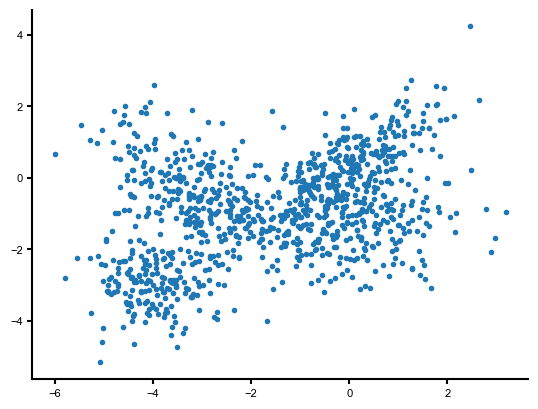

In [5]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")

In [6]:
def c2st_target(samples1, samples2, density1, density2):
    r"""Computes optimal C2ST and resulting classification cross-entropy loss
    for optimization
    """
    density_ratios1 = torch.stack([density1.log_prob(samples1), density2.log_prob(samples1)], dim=-1)
    density_ratios2 = torch.stack([density1.log_prob(samples2), density2.log_prob(samples2)], dim=-1)
    probs = torch.cat([density_ratios1, density_ratios2], dim=0)
    labels = torch.cat([torch.zeros(len(samples1)), torch.ones(len(samples2))], dim=0).long()
    loss = -nn.functional.cross_entropy(probs, labels)
    with torch.no_grad():
        c2st = (sum(density_ratios1[:, 0] >= density_ratios1[:, 1]) + sum(density_ratios2[:, 0] < density_ratios2[:, 1])) / (len(samples1) + len(samples2))
    return loss, c2st

In [7]:
n_iters = 100
num_samples = 10000
gauss_model_C2ST = Gauss(2)

model_toy_opt = torch.optim.Adam(gauss_model_C2ST.parameters(), lr=1e-2)

for epoch in range(n_iters):
    model_toy_opt.zero_grad()

    model_samples = gauss_model_C2ST.sample(num_samples)
    toy_samples = MOG.sample(num_samples)

    cent_loss, true_c2st = c2st_target(model_samples, toy_samples, gauss_model_C2ST, MOG)
    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 5 == 0:
        print("Iter: {}     loss: {}     c2st: {}".format(epoch, cent_loss.item(), true_c2st.item()))
    cent_loss.backward()
    model_toy_opt.step()

Iter: 0     loss: -0.46978697180747986     c2st: 0.7619500160217285
Iter: 5     loss: -0.4849301874637604     c2st: 0.7505000233650208
Iter: 10     loss: -0.502375066280365     c2st: 0.7373499870300293
Iter: 15     loss: -0.510179340839386     c2st: 0.7282000184059143
Iter: 20     loss: -0.5235998034477234     c2st: 0.7213000059127808
Iter: 25     loss: -0.5336400270462036     c2st: 0.7114999890327454
Iter: 30     loss: -0.5429686307907104     c2st: 0.69964998960495
Iter: 35     loss: -0.554060161113739     c2st: 0.6912000179290771
Iter: 40     loss: -0.5580413341522217     c2st: 0.6912500262260437
Iter: 45     loss: -0.5723074078559875     c2st: 0.6757500171661377
Iter: 50     loss: -0.5789155960083008     c2st: 0.6707500219345093
Iter: 55     loss: -0.5876372456550598     c2st: 0.6613500118255615
Iter: 60     loss: -0.5881165266036987     c2st: 0.664900004863739
Iter: 65     loss: -0.593040943145752     c2st: 0.6588000059127808
Iter: 70     loss: -0.6018864512443542     c2st: 0.64985

In [8]:
# MMD

gauss_model_MMD = Gauss(dim=2)
num_samples = 10000
with torch.no_grad():
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)
optimizer = torch.optim.Adam(gauss_model_MMD.parameters(), lr=0.01)
gauss_model_MMD.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model_MMD.zero_grad()
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_MMD.eval()



bandwidth:  tensor(2.9017)
Iter: 0     loss: 0.17773091793060303
Iter: 1     loss: 0.17023885250091553
Iter: 2     loss: 0.1690148115158081
Iter: 3     loss: 0.16441738605499268
Iter: 4     loss: 0.15770745277404785
Iter: 5     loss: 0.15960538387298584
Iter: 6     loss: 0.1601647138595581
Iter: 7     loss: 0.15434229373931885
Iter: 8     loss: 0.1462407112121582
Iter: 9     loss: 0.14414441585540771
Iter: 10     loss: 0.1465820074081421
Iter: 11     loss: 0.13647890090942383
Iter: 12     loss: 0.13568341732025146
Iter: 13     loss: 0.13663148880004883
Iter: 14     loss: 0.13309407234191895
Iter: 15     loss: 0.12391018867492676
Iter: 16     loss: 0.1312168836593628
Iter: 17     loss: 0.12392783164978027
Iter: 18     loss: 0.12224781513214111
Iter: 19     loss: 0.10962343215942383


Gauss()

In [9]:
# WS

gauss_model_WS = Gauss(dim=2)
optimizer = torch.optim.Adam(gauss_model_WS.parameters(), lr=0.1)
gauss_model_WS.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model_WS.zero_grad()
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = sliced_wasserstein_distance(samples, uniform_samples)#, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_WS.eval()



Iter: 0     loss: 1.54488205909729
Iter: 1     loss: 1.4496546983718872
Iter: 2     loss: 1.3768030405044556
Iter: 3     loss: 1.1435351371765137
Iter: 4     loss: 1.0664546489715576
Iter: 5     loss: 1.008043646812439
Iter: 6     loss: 0.93028324842453
Iter: 7     loss: 0.8568893671035767
Iter: 8     loss: 0.6566576957702637
Iter: 9     loss: 0.6163392663002014
Iter: 10     loss: 0.6063021421432495
Iter: 11     loss: 0.4940948188304901
Iter: 12     loss: 0.4298429489135742
Iter: 13     loss: 0.41841864585876465
Iter: 14     loss: 0.3614538609981537
Iter: 15     loss: 0.3637193739414215
Iter: 16     loss: 0.3118676543235779
Iter: 17     loss: 0.29383620619773865
Iter: 18     loss: 0.2549360692501068
Iter: 19     loss: 0.2481897473335266


Gauss()

In [54]:
#FROM: https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=[1,2], ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for std in nstd:
    # Width and height are "full" widths, not radius
        width, height = 2 * std * np.sqrt(vals)
        print(pos,width, height,theta)
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        ax.add_artist(ellip)
    return ellip

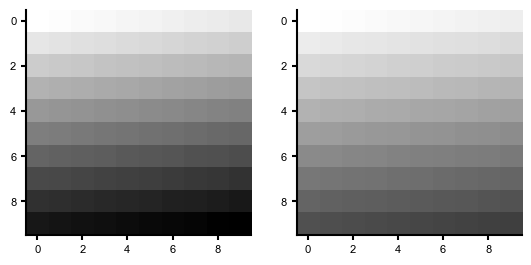

In [71]:
# FROM: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_yarg')
new_cmap = truncate_colormap(cmap, 0, 0.75)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [75]:
num_samples = 10000
#SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
#MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
#C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
#SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
#MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
#C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,4, figsize = (6.5,3))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y',cmap="Blues", fill=True,levels=12)#, thresh=.1,)#, color="black",alpha=0.75, levels=5)

alpha_bg=1
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[3],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)

#x, y = np.mgrid[-10:10:.1, -10:10:.1]
#z =torch.exp(gauss_model_WS.log_prob(data)).detach().numpy()
##axs[1].contour(x, y, z,colors ='#cc241d')#), cmap='coolwarm',fill=False)
##z =torch.exp(gauss_model_MMD.log_prob(data)).detach().numpy()
#axs[2].contour(x, y, z,colors ='#eebd35')#), cmap='coolwarm',fill=False)
#z =torch.exp(gauss_model_C2ST.log_prob(data)).detach().numpy()
#axs[3].contour(x, y, z,colors ="#458588")#), cmap='coolwarm',fill=False)
std_plot = [np.sqrt(.25),np.sqrt(.5),np.sqrt(1),np.sqrt(2)]
std_plot=[.25,.5,1,2]
plot_cov_ellipse(gauss_model_WS.cov().detach().numpy(),gauss_model_WS.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[1],edgecolor='#cc241d', lw=1.5, facecolor='none')
#axs[1].scatter(gauss_model_WS.mean.detach().numpy()[0],gauss_model_WS.mean.detach().numpy()[1],
#               color='#cc241d',s=1.5)
plot_cov_ellipse(gauss_model_MMD.cov().detach().numpy(),gauss_model_MMD.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[3],edgecolor='#eebd35', lw=1.5, facecolor='none')
plot_cov_ellipse(gauss_model_C2ST.cov().detach().numpy(),gauss_model_C2ST.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[2],edgecolor='#458588', lw=1.5, facecolor='none')

#sns.kdeplot(ax=axs[1],data=SWD_df, x='x', y='y', fill=False,cmap ="Reds",levels=7)#,color="#cc241d",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[2],data=MMD_df, x='x', y='y', fill=False,cmap='Wistia',levels=7)#color="#eebd35",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[3],data=C2ST_df, x='x', y='y', fill=False,cmap='Blues',levels=7)#color="#eebd35",alpha=.5, levels=5)
#color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-8,5)
    ax.set_ylim(-7,4)
    #make square subplots 
    ax.set_box_aspect(1)
axs[0].set_title(r"$p_{true}$")
axs[1].set_title("SWD",color ='#cc241d')
axs[3].set_title("MMD " +r"($K_G$)",color ='#eebd35')
axs[2].set_title("C2ST",color ="#458588")

fig.tight_layout()
plt.savefig("mode.pdf")

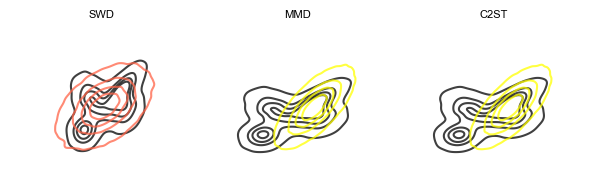

In [11]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()
